In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import h5py
import threading

In [2]:
# x = [ r, z ]
# c = [ n0, epsilon, lambda ]
def a(x,c):
    return 1+c[1]*np.cos(2*np.pi*x[1]/c[2])
def n (x,c) :
    if x[0] <= a(x,c) :
        return np.sqrt(c[0]**2 - (c[0]**2 - 1.0) * x[0]**2)
    elif x[0] > a(x,c) :
        return 1.0
def dndr (x,c) :
    if x[0] <= a(x,c) :
        return -(c[0]**2-1.0)*x[0]/(a(x,c)*np.sqrt(c[0]**2-(c[0]**2-1)*x[0]**2/a(x,c)))                    
    elif x[0] > a(x,c) : 
        return 0.0
def dndz (x,c) :
    if x[0] <= a(x,c) :
        return -c[1]*np.pi*(c[0]**2-1.0)*x[0]**2*np.sin(2*np.pi*x[1]/c[2])/(c[2]*a(x,c)**2*np.sqrt(c[0]**2-(c[0]**2-1)*x[0]**2/a(x,c)))
    elif x[0] > a(x,c) : 
        return 0.0

In [3]:
def func ( x,c ) : # x = [r,z]
    return np.array([x[2]/n(x,c)**2,
                     x[3]/n(x,c)**2,
                     dndr(x,c)/n(x,c),
                     dndz(x,c)/n(x,c)])

In [4]:
def RK(t,x0,c):

    k = np.zeros((4,4),dtype = 'complex64')
    x = np.zeros((t.size,4),dtype = 'complex64')
    x[0] = x0
    h = t[1]-t[0]

    for i in range(1, t.size):
        k[0] = func(x[i-1], c)
        k[1] = func(x[i-1]+h*k[0]/2, c)
        k[2] = func(x[i-1]+h*k[1]/2, c)
        k[3] = func(x[i-1]+h*k[2], c)

        x[i] = x[i-1]+h*(k[0]+2*k[1]+2*k[2]+k[3])/6
    return x

In [5]:
x0 = np.array([0.9, 0.0, 0.0, 1.0])
c = [2.0, 0.0, 1.0]
t = np.linspace(0, 30, 20000)
res = RK(t,x0, c)

/home/caleb/Jupyter Lab/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/caleb/Jupyter Lab/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


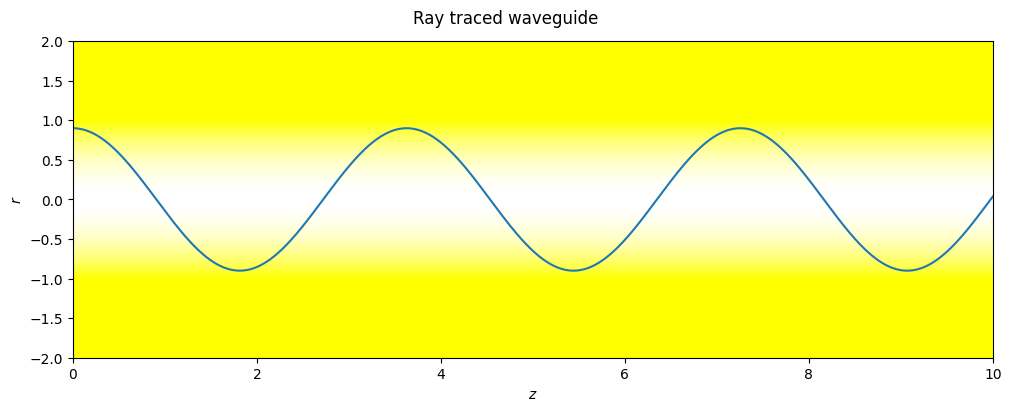

In [6]:
fig = plt.figure(figsize=(10,4), layout='constrained')
fig.suptitle(r'Ray traced waveguide')
ax1 = fig.add_subplot(1, 1, 1, title='', xlabel=r'$z$', ylabel=r'$r$')
ax1.set_ylim([-2, 2])
x_max = 10.0
ax1.set_xlim([0, x_max])

x = np.linspace(0, x_max, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

alpha = np.clip(Y**2, 0,1)

color = np.zeros((Y.shape[0], X.shape[1], 4))  # RGBA
color[..., 0:2] = 1.0  # blue channel
color[..., 3] = alpha  # alpha channel
ax1.imshow(color, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')

ax1.plot(res[:,1], res[:,0]);

In [31]:
def make_rays(min_val, max_val, num_rays, eps, lam):
    fig = plt.figure(figsize=(200,8), layout='constrained')
    fig.suptitle(r'Ray traced waveguide')
    ax1 = fig.add_subplot(1, 1, 1, title='', xlabel=r'$z$', ylabel=r'$r$')
    ax1.set_ylim([-2, 2])
    x_max = 100.0
    ax1.set_xlim([0, x_max])
    
    x = np.linspace(0, x_max, 500)
    y = np.linspace(-2, 2, 500)
    X, Y = np.meshgrid(x, y)
    
    alpha = np.clip(Y**2/(1+eps*np.cos(2*np.pi*X/lam)), 0,1)
    
    color = np.zeros((Y.shape[0], X.shape[1], 4))  # RGBA
    color[..., 0:2] = 1.0  # blue channel
    color[..., 3] = alpha  # alpha channel
    ax1.imshow(color, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
    
    def ray_calc( t, x0, c, res, index ):
        res[index] = RK(t, x0, c)
    
    rays = np.linspace(min_val, max_val, num_rays)
    threads = [None] * num_rays
    res = [None] * num_rays

    t = np.linspace(0, 400, 10000)
    c = [2.0, eps, lam]

    for i in range(len(threads)):
        threads[i] = threading.Thread(target=ray_calc, args=(t,[rays[i],0.0,0.0,1.0],c,res,i))
        threads[i].start()
    
    for i in range(len(threads)):
        threads[i].join()
    
    for i in res :
        ax1.plot(i[:,1], i[:,0]);

$\epsilon = 0$

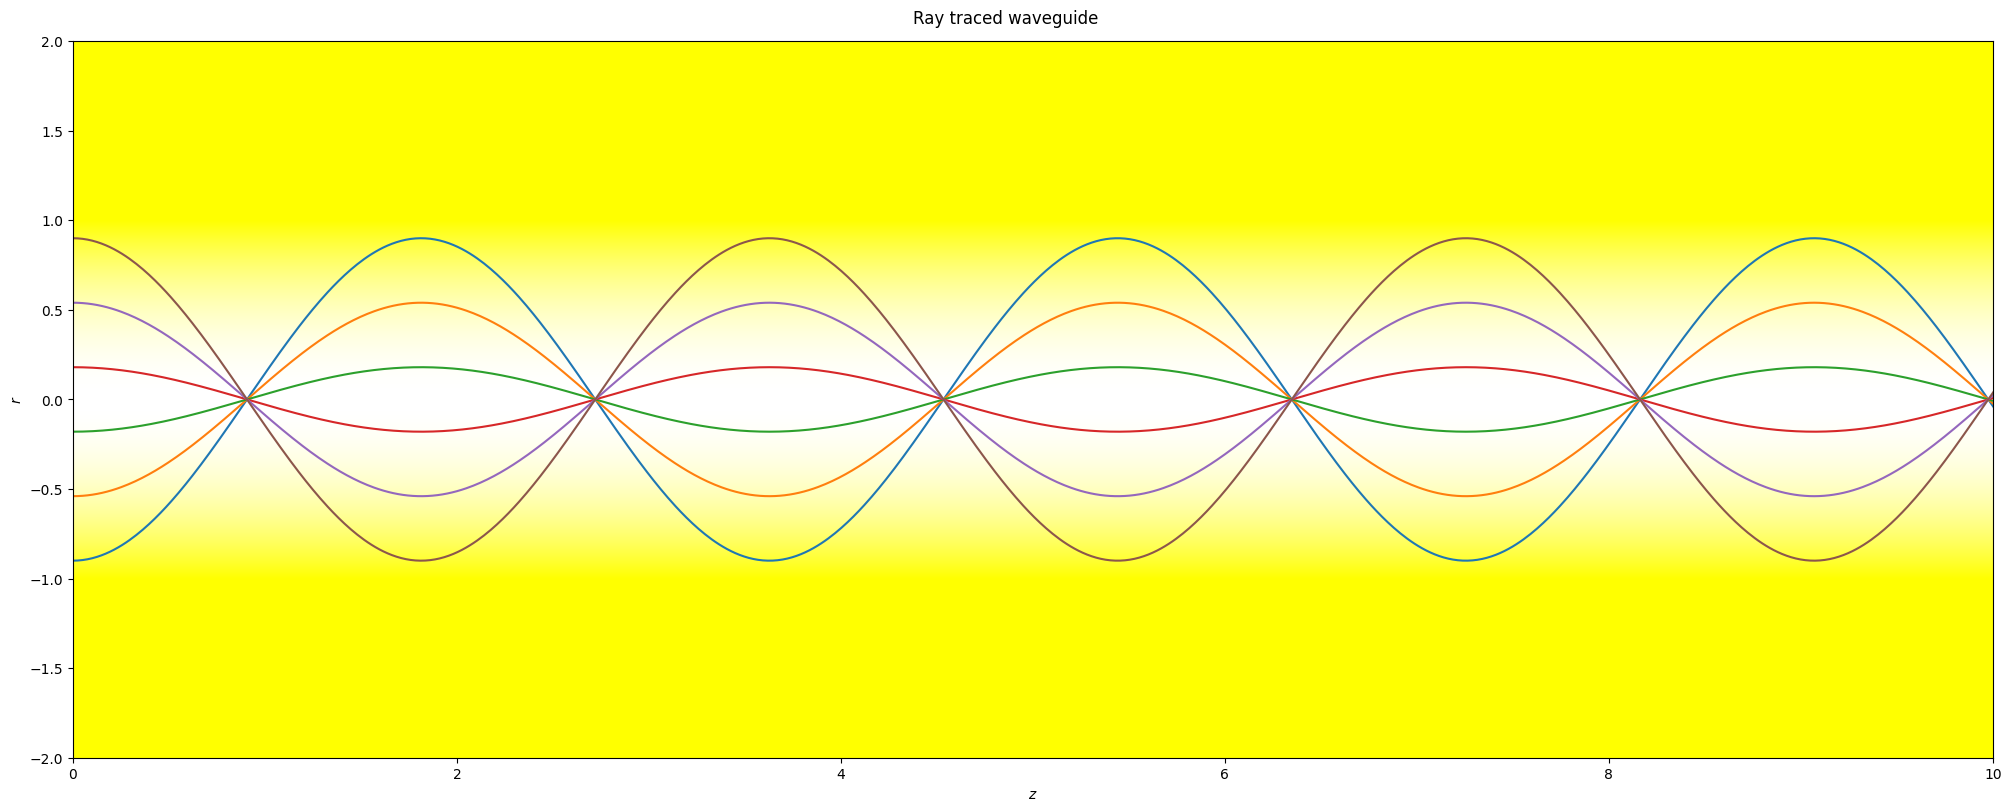

In [23]:
make_rays(-0.9,0.9,6,0.0,1.0)

$\epsilon = 0.1$ \
$\lambda = 1.0$

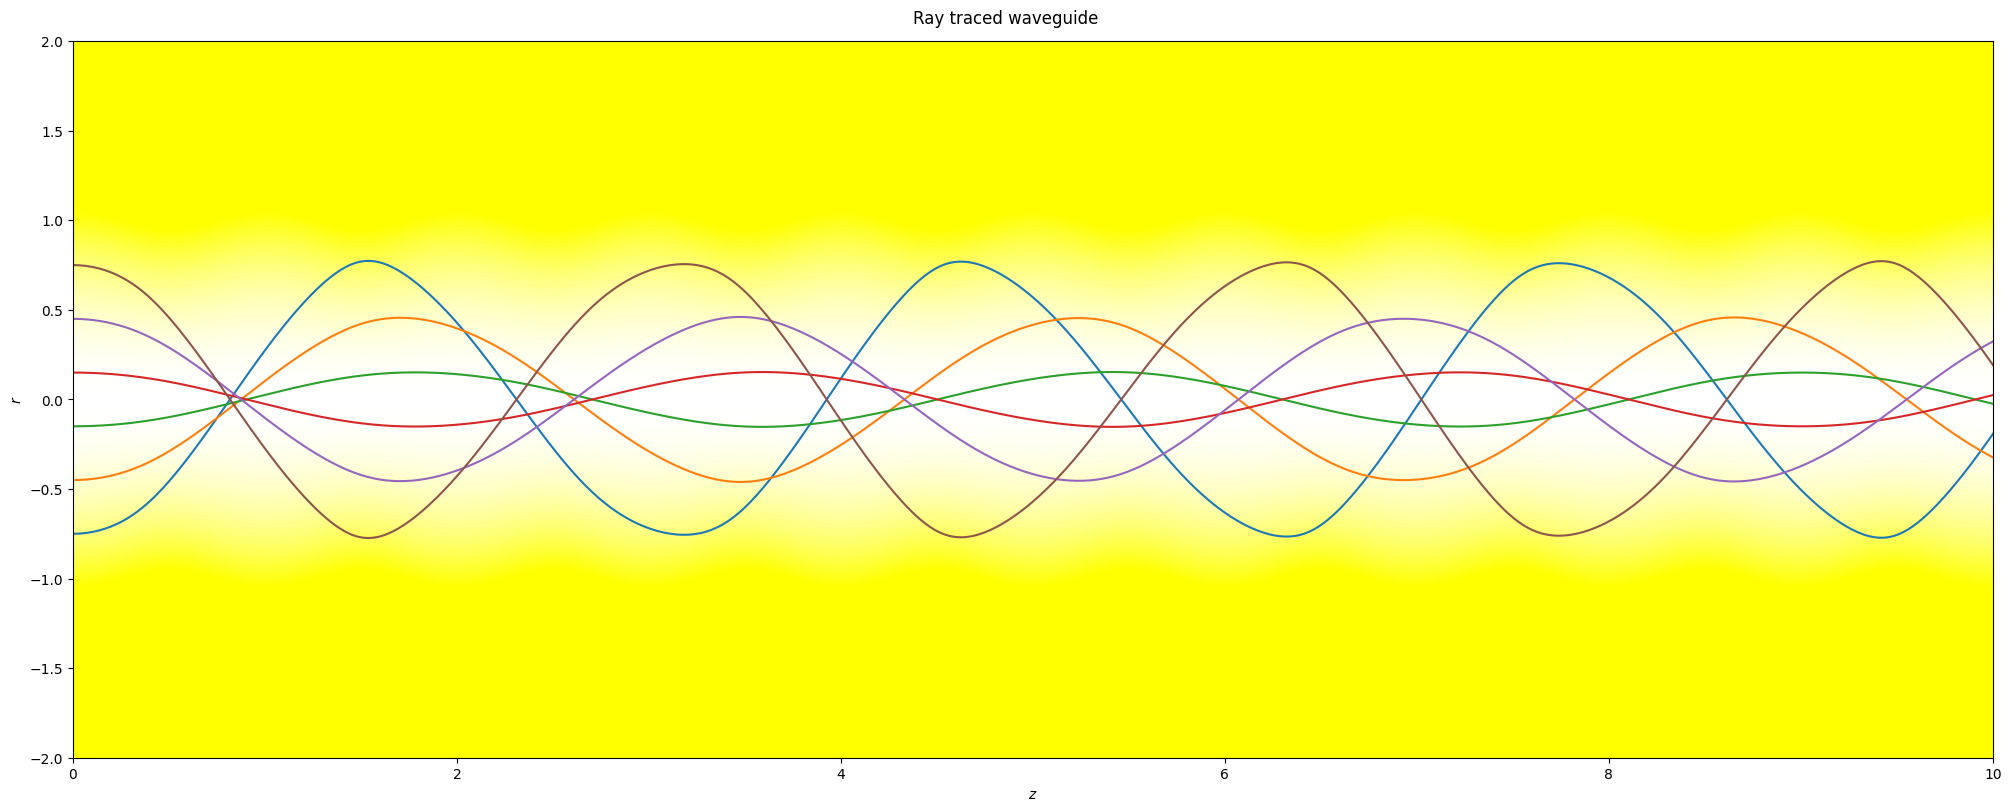

In [25]:
make_rays(-0.75,0.75,6,0.1,1.0)

$\epsilon = 0.3$ \
$\lambda = Z_03/2$

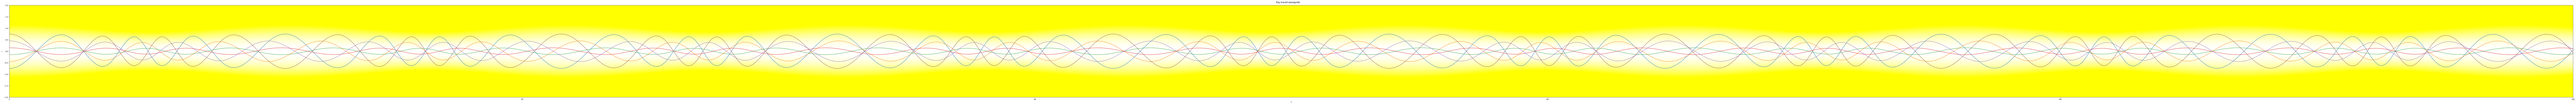

In [34]:
n0 = 2.0
Z0 = 2*np.pi*n0/np.sqrt(n0**2-1)
make_rays(-0.75,0.75,6,0.3,Z0*3/2)

In [ ]:
n0 = 2.0
Z0 = 2*np.pi*n0/np.sqrt(n0**2-1)
make_rays(-0.75,0.75,6,0.3,Z0*3/2)